### Kaggle competition Energy consumption prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from myfunc import get_stats
import gc

pd.set_option('display.max_columns', 300)

#### Import necessary data

In [2]:
root = '../data/'

train = pd.read_csv(root + 'train.csv')
weather_train = pd.read_csv(root + 'weather_train.csv')

test = pd.read_csv(root + 'test.csv')
weather_test = pd.read_csv(root + 'weather_test.csv')

building = pd.read_csv(root + 'building_metadata.csv')


In [3]:
print('Size of train data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building data', building.shape)

Size of train data (20216100, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building data (1449, 6)


In [4]:
# train.csv
# building_id - Foreign key for the building metadata.
# meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
# timestamp - When the measurement was taken
# meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.
# building_meta.csv
# site_id - Foreign key for the weather files.
# building_id - Foreign key for training.csv
# primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
# square_feet - Gross floor area of the building
# year_built - Year building was opened
# floor_count - Number of floors of the building
# weather_[train/test].csv
# Weather data from a meteorological station as close as possible to the site.

# site_id
# air_temperature - Degrees Celsius
# cloud_coverage - Portion of the sky covered in clouds, in oktas
# dew_temperature - Degrees Celsius
# precip_depth_1_hr - Millimeters
# sea_level_pressure - Millibar/hectopascals
# wind_direction - Compass direction (0-360)
# wind_speed - Meters per second

### Preprocessing/EDA

In [5]:
get_stats(train)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,building_id,1449,0.0,0.043451,0.173802,int64
1,meter,4,0.0,59.659925,59.659925,int64
2,timestamp,8784,0.0,0.000000,0.011723,object
3,meter_reading,1688175,0.0,9.269721,9.269721,float64


In [6]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [7]:
get_stats(weather_train)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,site_id,16,0.000000,6.284476,6.284476,int64
1,timestamp,8784,0.000000,0.000000,0.011447,object
2,air_temperature,619,0.039350,0.580942,1.947443,float64
3,cloud_coverage,10,49.489529,24.232863,49.489529,float64
4,dew_temperature,522,0.080845,1.440192,1.973915,float64
5,precip_depth_1_hr,128,35.979052,55.740379,55.740379,float64
6,sea_level_pressure,709,7.596603,0.000000,7.596603,float64
7,wind_direction,43,4.484414,9.410974,9.410974,float64
8,wind_speed,58,0.217496,9.688566,10.288825,float64


In [8]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [9]:
get_stats(building)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,site_id,16,0.000000,7.246377,18.909593,int64
1,building_id,1449,0.000000,0.069013,0.069013,int64
2,primary_use,16,0.000000,0.000000,37.888199,object
3,square_feet,1397,0.000000,0.000000,0.483092,int64
4,year_built,116,53.416149,0.000000,53.416149,float64
5,floor_count,18,75.500345,0.000000,75.500345,float64


In [10]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [11]:
train=train.merge(building, on=['building_id'], how='left')
train=train.merge(weather_train, on=['timestamp', 'site_id'], how='left')

In [12]:
test=test.merge(building, on=['building_id'], how='left')
test=test.merge(weather_test, on=['timestamp', 'site_id'], how='left')

In [13]:
del weather_train, weather_test, building
gc.collect()

528

In [14]:
get_stats(train)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,building_id,1449,0.000000,0.043451,0.173802,int64
1,meter,4,0.000000,59.659925,59.659925,int64
2,timestamp,8784,0.000000,0.000000,0.011723,object
3,meter_reading,1688175,0.000000,9.269721,9.269721,float64
4,site_id,16,0.000000,5.325765,13.413878,int64
5,primary_use,16,0.000000,0.000000,40.391094,object
6,square_feet,1397,0.000000,0.000000,0.304154,int64
7,year_built,116,59.990033,0.000000,59.990033,float64
8,floor_count,18,82.652772,0.000000,82.652772,float64
9,air_temperature,619,0.478124,0.699823,1.958662,float64


In [15]:

# building_id=175
# meter_id=1

# some_building=train.query(f'building_id=={building_id} and meter=={meter_id}')[['meter_reading', 'timestamp']]
# some_building['timestamp']=pd.to_datetime(some_building['timestamp'])
# some_building.set_index('timestamp', inplace=True)
# some_building.plot() 
# #some_building['2016-08-01':'2016-08-03'].plot() 

#### Feature engineering

In [16]:
#buildingtype/chars

In [17]:
#parse timestamp
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['hour'] = train['timestamp'].dt.hour
train['day'] = train['timestamp'].dt.day
train['weekday'] = train['timestamp'].dt.weekday
train['month'] = train['timestamp'].dt.month
train['weekend'] = np.where(train['weekday']>=5, 1, 0)
train['work_time'] = np.where((train['hour']>=9)&(train['hour']<=18)&(train['weekend']==0), 1, 0) 
train['season'] = (train['month']%12 + 3)//3
train.drop('timestamp', axis=1, inplace=True)
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,weekend,work_time,season
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1


In [18]:
#encode 'primary_use'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(train['primary_use'])
train['primary_use'] = le.transform(train['primary_use'])

# One-hot?

In [19]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,weekend,work_time,season
0,0,0,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
1,1,0,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
2,2,0,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
3,3,0,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1
4,4,0,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,0,1


Drop unnecessary features

In [20]:
drop_cols = ['precip_depth_1_hr'
             , 'floor_count'
             , 'year_built'
             , 'cloud_coverage'
             , 'sea_level_pressure'
             , 'wind_direction'
            ]
train.drop(drop_cols, axis=1, inplace=True)
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,hour,day,weekday,month,weekend,work_time,season
0,0,0,0.0,0,0,7432,25.0,20.0,0.0,0,1,4,1,0,0,1
1,1,0,0.0,0,0,2720,25.0,20.0,0.0,0,1,4,1,0,0,1
2,2,0,0.0,0,0,5376,25.0,20.0,0.0,0,1,4,1,0,0,1
3,3,0,0.0,0,0,23685,25.0,20.0,0.0,0,1,4,1,0,0,1
4,4,0,0.0,0,0,116607,25.0,20.0,0.0,0,1,4,1,0,0,1


In [21]:
get_stats(train)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,building_id,1449,0.000000,0.043451,0.173802,int64
1,meter,4,0.000000,59.659925,59.659925,int64
2,meter_reading,1688175,0.000000,9.269721,9.269721,float64
3,site_id,16,0.000000,5.325765,13.413878,int64
4,primary_use,16,0.000000,40.391094,40.391094,int32
5,square_feet,1397,0.000000,0.000000,0.304154,int64
6,air_temperature,619,0.478124,0.699823,1.958662,float64
7,dew_temperature,522,0.495348,1.640549,1.978730,float64
8,wind_speed,58,0.710701,11.796345,11.796345,float64
9,hour,24,0.000000,4.166882,4.169266,int64


In [22]:
# impute temperature and windspeed by mean value
train['air_temperature'].fillna(train['air_temperature'].mean(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].mean(), inplace=True)
train['wind_speed'].fillna(train['wind_speed'].mean(), inplace=True)

In [23]:
get_stats(train)

,Feature,Unique_values,Percentage of missing values,Percentage of zero values,Percentage of values in the biggest category,type
0,building_id,1449,0.0,0.043451,0.173802,int64
1,meter,4,0.0,59.659925,59.659925,int64
2,meter_reading,1688175,0.0,9.269721,9.269721,float64
3,site_id,16,0.0,5.325765,13.413878,int64
4,primary_use,16,0.0,40.391094,40.391094,int32
5,square_feet,1397,0.0,0.000000,0.304154,int64
6,air_temperature,620,0.0,0.699823,1.958662,float64
7,dew_temperature,523,0.0,1.640549,1.978730,float64
8,wind_speed,59,0.0,11.796345,11.796345,float64
9,hour,24,0.0,4.166882,4.169266,int64


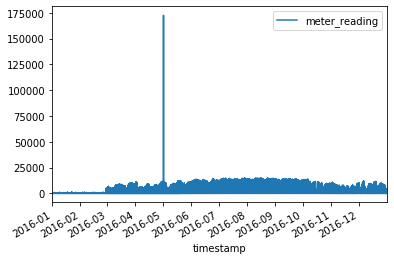

In [19]:
#looks like there may be some errors with some of the readings
train[train['site_id'] == 0].plot('timestamp', 'meter_reading')

In [28]:
X = pd.DataFrame({'a':[1,2,3,4,5],'b':[10,23,344,213,12]})
X.head()

,a,b
0,1,10
1,2,23
2,3,344
3,4,213
4,5,12


In [36]:
X['c']=np.where(X['a']>=5, 'yes', 'no')
X.head()

,a,b,c
0,1,10,no
1,2,23,no
2,3,344,no
3,4,213,no
4,5,12,yes


Modelling

In [ ]:
y = np.log1p(train[['meter_reading']].values.reshape(-1,1))
preds = np.expm1(clf.predict(test))

In [ ]:
gc.collect()
folds = 3
seed = 222
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_valid_pred = np.zeros(X_train.shape[0])
models = []

for tr_idx, val_idx in kf.split(X_train, y_train):
    tr_x, tr_y = X_train.iloc[tr_idx,:], y_train[tr_idx]
    vl_x, vl_y = X_train.iloc[val_idx,:], y_train[val_idx]
            
    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    clf = lgb.LGBMRegressor(n_estimators=200,learning_rate=0.2,feature_fraction=0.9,
            bagging_fraction=0.9,early_stopping_rounds=50)
    clf.fit(tr_x, tr_y,
        eval_set=[(vl_x, vl_y)],
        verbose=True)
    y_valid_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
    models.append(clf)
    gc.collect()

Evaluation

In [ ]:
#Since the minimum value is 0, it was clipped to do so.
print('valid score is',np.sqrt(sum(np.power(y_train-np.clip(y_valid_pred,0,None),2))/y_train.shape[0]))

In [ ]:
sample_submission['meter_reading'] = np.clip(preds, 0, 121904700.0)
sample_submission.head()

In [ ]:
sample_submission.to_csv('simple_linear_banchmar.csv', index=False)
